<a href="https://colab.research.google.com/github/HuanciWang/Business-Economics-Honors-Program/blob/main/criteo1_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gzip
import urllib.request

baseURL = "http://go.criteo.net/"
filename = "criteo-research-uplift-v2.1.csv.gz"
outFilePath = filename[:-3]
download_file = True

if download_file:
  response = urllib.request.urlopen(baseURL + filename)
  with open(outFilePath, 'wb') as outfile:
      outfile.write(gzip.decompress(response.read()))

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

# Import and shuffle data
df_all = pd.read_csv('criteo-research-uplift-v2.1.csv')
df_all = shuffle(df_all, random_state=20)
df_treated = df_all[df_all.treatment == 1]
df_treated = shuffle(df_treated, random_state=20)
df_untreated = df_all[df_all.treatment == 0]
df_untreated = shuffle(df_untreated, random_state=20)
df_all.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'treatment', 'conversion', 'visit', 'exposure'],
      dtype='object')

In [3]:
#These are the number of rows in each file. Treated and Untreated data were extracted from the total data.
count_all = df_all['conversion'].count()
count_treated = df_treated['conversion'].count()
count_untreated = df_untreated['conversion'].count()
print(count_all,count_treated,count_untreated)

13979592 11882655 2096937


In [4]:
#conversion rate
print('conversion rate:', df_all.conversion[df_all.conversion == 1].count()/count_all)
print('conversion rate:', df_treated.conversion[df_all.conversion == 1].count()/count_treated)
print('conversion rate:', df_untreated.conversion[df_untreated.conversion == 1].count()/count_untreated)

conversion rate: 0.002916680257907384
conversion rate: 0.0030894610674129645
conversion rate: 0.0019375880152813366


#### By the number of untreated data, select these numbers of data randomly from all/treated/untreated
* 60% train = 1258163
* 20% validation = 419387
* 20% test = 419387
#### To do this, I shuffle each dataset and choose corresponding number of rows from them, so that we are in fact randomly selecting our training, validating and testing set

In [5]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

train_size = 1258163   
#val_size = 419387
val_size = 800000
test_size = 419387
# Get the training data
features = ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']
X_train_tr, y_train_tr = df_treated[features][:train_size], df_treated['conversion'][:train_size]
X_train_un, y_train_un = df_untreated[features][:train_size], df_untreated['conversion'][:train_size]
# Get the validation data
treated_rate = df_all.treatment.mean()
tr_val_size = int(val_size*treated_rate)
un_val_size = int(val_size*(1-treated_rate))
df_val = pd.concat([df_treated[train_size:(train_size+tr_val_size)], df_untreated[train_size:(train_size+un_val_size)]])
df_val = shuffle(df_val, random_state=20)
X_val, y_val = df_val[features], df_val['conversion']

In [6]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


def inner_cv(X_train, y_train, learner):
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = learner(random_state=1)
    # define search space
    space = dict()
    a = 500000 #for now
    #space['min_samples_split'] = [0.01,0.05,0.1,0.2,0.3,0.4,0.5]*a 
    space['min_samples_split'] = (np.array([0.1,0.2,0.3,0.4,0.5])*a).astype(int) 
    #I found over fitting when using 0.01, 0.05 for min_samples_split
    # define search
    search = GridSearchCV(model, space, scoring='roc_auc', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    return best_model

## Model 3: Treated data, predict conversion

In [7]:
clf_treated = inner_cv(X_train_tr, y_train_tr, DecisionTreeClassifier)
fpr, tpr, thresholds = metrics.roc_curve(y_val, clf_treated.predict_proba(X_val)[:,1])
print(f"AUC: {metrics.auc(fpr, tpr)}")

AUC: 0.9454150731544698


## Model 5: Untreated data, predict conversion

In [8]:
clf_untreated = inner_cv(X_train_un, y_train_un, DecisionTreeClassifier)
fpr, tpr, thresholds = metrics.roc_curve(y_val, clf_untreated.predict_proba(X_val)[:,1])
print(f"AUC: {metrics.auc(fpr, tpr)}")

AUC: 0.9439869166672776


## Model 1 Prediction
### After building the models, we do evaluation and prediction using validation data
* some data in val_set might be the same with training data in untreated/treated data set
* val_set is completely separated from training data of model 1

## Now we see the features of the validation set

In [9]:
#porportion of people treated
targeted = df_val.treatment.mean()
treat_all = df_val[df_val.treatment == 1].conversion.mean()
treat_none = df_val[df_val.treatment == 0].conversion.mean()
treat_random = treat_all*targeted+treat_none*(1-targeted)
print(f"Percentage of people targeted: {targeted}")
print(f"Conversion rate on treated: {treat_all}")
print(f"Conversion rate on untreated: {treat_none}")
print(f"Conversion rate on validation set: {treat_random}")

Percentage of people targeted: 0.8500010625013281
Conversion rate on treated: 0.003048529411764706
Conversion rate on untreated: 0.001816681805681714
Conversion rate on validation set: 0.0028637535796919747


## Now, we target top 10% and see the result

In [10]:
def do_targeting(scores, val_set):
    # Do the targeting
    target_size = int(val_set.shape[0] * 0.10)
    top_individuals = np.argsort(scores)[-target_size:]
    target_decisions = np.zeros(val_set.shape[0])
    target_decisions[top_individuals] =  1
    # Estimate rewards
    matches = target_decisions == val_set.treatment.values
    treatment_rate = val_set.treatment.mean()
    weights = val_set.treatment * treatment_rate + (1 - val_set.treatment) * (1 - treatment_rate)
    rewards = val_set.conversion.values * matches / weights
    print("Reward distribution:")
    print(rewards.value_counts())
    treat_with_model = rewards.mean()
    for_target_treated = val_set[target_decisions * val_set.treatment == 1].conversion.mean()
    for_target_untreated = val_set[target_decisions * (1-val_set.treatment) == 1].conversion.mean()
    effect_for_targeted = for_target_treated - for_target_untreated
    results = pd.DataFrame({"avg_reward":[treat_with_model], "for_target_treated":[for_target_treated], 
                            "for_target_untreated": [for_target_untreated], "effect_for_targeted":[effect_for_targeted]})
    return results, target_decisions

# Targeting and causal effect for the treated model
tr_scores = clf_treated.predict_proba(X_val)[:, 1]
results_tr, tr_decisions = do_targeting(tr_scores, df_val)
# Targeting and causal effect for the untreated model
un_scores = clf_untreated.predict_proba(X_val)[:, 1]
results_un, un_decisions = do_targeting(un_scores, df_val)
# Targeting and causal effect for the uplift model
up_scores = tr_scores - un_scores
results_up, up_decisions = do_targeting(up_scores, df_val)
# Report results
summary = pd.concat([results_tr, results_un, results_up])

summary['model'] = ['model_treated', 'model_untreated', 'uplift']
summary.set_index('model')
#result = pd.DataFrame(np.array([np.array(effect1),np.array(effect3),np.array(effect5),np.array(effect_up)]),index = ['model_all','model_treated','model_untreated','uplift'],columns = ['treat_with_model','for_target_treated','for_target_untreated','avg_effect','effect_for_targeted'])
#result

Reward distribution:
0.000000    798168
1.176469      1796
6.666714        35
Name: treatment, dtype: int64
Reward distribution:
0.000000    798167
1.176469      1803
6.666714        29
Name: treatment, dtype: int64
Reward distribution:
0.000000    798748
1.176469      1134
6.666714       117
Name: treatment, dtype: int64


,avg_reward,for_target_treated,for_target_untreated,effect_for_targeted
model,,,,
model_treated,0.002933,0.026024,0.016658,0.009367
model_untreated,0.002893,0.026192,0.016932,0.009260
uplift,0.002643,0.016466,0.009075,0.007391


### Use Spearman correlation to see how closely these models are ranking things

In [11]:
from scipy import stats

print(stats.spearmanr(tr_scores, un_scores))
print(stats.spearmanr(tr_scores, up_scores))
print(stats.spearmanr(un_scores, up_scores))

SpearmanrResult(correlation=0.7457900226791097, pvalue=0.0)
SpearmanrResult(correlation=0.5764227027818677, pvalue=0.0)
SpearmanrResult(correlation=0.10055398199862103, pvalue=0.0)


* untreated vs up score, why un similar with tr but not up?
* range matters? bins (target ranges, spearman for ranges)
* are top targets same? (1 only)

In [12]:
# Matching decisions (>80%)
print((tr_decisions == un_decisions).mean())
print((tr_decisions == up_decisions).mean())
print((un_decisions == up_decisions).mean())

0.95844744805931
0.9463599329499162
0.9062848828561035


In [13]:
# Matching decisions (same and positive decision, >0%, this is similarity not accuracy)
print((un_decisions[tr_decisions==1] == 1).mean())
print((tr_decisions[up_decisions==1] == 1).mean())
print((un_decisions[up_decisions==1] == 1).mean())

0.7922349029362867
0.7317966474580933
0.5314191427392843


* lift? (positive decisions). The least is 80%

In [14]:
print(stats.spearmanr(tr_decisions, un_decisions))
print(stats.spearmanr(tr_decisions, up_decisions))
print(stats.spearmanr(un_decisions, up_decisions))

SpearmanrResult(correlation=0.7691501807140643, pvalue=0.0)
SpearmanrResult(correlation=0.7019966474580926, pvalue=0.0)
SpearmanrResult(correlation=0.47935525385039646, pvalue=0.0)


In [15]:
# Precision (0.003 in the totel population) ranking all: AUC, ranking top: precision
print(df_val.loc[tr_decisions==1,"conversion"].mean())
print(df_val.loc[un_decisions==1,"conversion"].mean())
print(df_val.loc[up_decisions==1,"conversion"].mean()) # much lower but uplift is not looking at conversion!

0.024737809222615283
0.024900311253890674
0.01543769297116214


## **Precision learning curve:**

## Learning curve 12.20

In [16]:
def auc(scores, ground_truth):
    fpr, tpr, thresholds = metrics.roc_curve(ground_truth, scores)
    return metrics.auc(fpr, tpr)

### Model 1: All data, conversion

In [17]:
def get_learning_curves():
    all_aucs = []
    all_effects = []
    all_rewards = [] 
    #prct = [0.01,0.05,0.1,0.2,0.3,0.4,0.5]
    prct = [0.1,0.2,0.3,0.4,0.5, 1]
    model_un_all = inner_cv(X_train_un, y_train_un, DecisionTreeClassifier) 
    for l in prct:
        row_aucs = []
        row_effects = []
        row_rewards = []
        learn_size = int(train_size*l)
        model_tr = inner_cv(X_train_tr[:learn_size], y_train_tr[:learn_size], DecisionTreeClassifier)
        model_un = inner_cv(X_train_un[:learn_size], y_train_un[:learn_size], DecisionTreeClassifier)
        scores_tr = model_tr.predict_proba(X_val)[:, 1]
        scores_un = model_un.predict_proba(X_val)[:, 1]
        scores_up = scores_tr - model_un_all.predict_proba(X_val)[:, 1]
        for scores in [scores_tr, scores_un, scores_up]:
            row_aucs.append(auc(scores, y_val))
            results, _ = do_targeting(scores, df_val)
            row_rewards.append(results["avg_reward"][0])
            row_effects.append(results["effect_for_targeted"][0])
        all_aucs.append(row_aucs)
        all_effects.append(row_effects)
        all_rewards.append(row_rewards)
    return all_aucs, all_effects, all_rewards

Reward distribution:
0.000000    798271
1.176469      1691
6.666714        37
Name: treatment, dtype: int64
Reward distribution:
0.000000    798368
1.176469      1589
6.666714        42
Name: treatment, dtype: int64
Reward distribution:
0.000000    799028
1.176469       829
6.666714       142
Name: treatment, dtype: int64
Reward distribution:
0.000000    798243
1.176469      1717
6.666714        39
Name: treatment, dtype: int64
Reward distribution:
0.000000    798275
1.176469      1681
6.666714        43
Name: treatment, dtype: int64
Reward distribution:
0.000000    799112
1.176469       739
6.666714       148
Name: treatment, dtype: int64
Reward distribution:
0.000000    798284
1.176469      1672
6.666714        43
Name: treatment, dtype: int64
Reward distribution:
0.000000    798263
1.176469      1693
6.666714        43
Name: treatment, dtype: int64
Reward distribution:
0.000000    798471
1.176469      1473
6.666714        55
Name: treatment, dtype: int64
Reward distribution:
0.00000

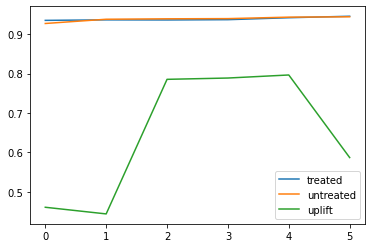

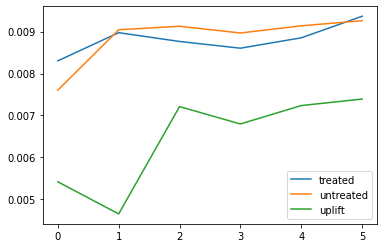

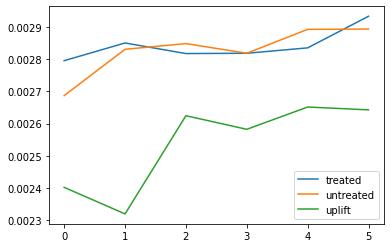

In [18]:
aucs, rewards, effects = get_learning_curves()
pd.DataFrame(aucs, columns=["treated", "untreated", "uplift"]).plot()
pd.DataFrame(rewards, columns=["treated", "untreated", "uplift"]).plot()
pd.DataFrame(effects, columns=["treated", "untreated", "uplift"]).plot()

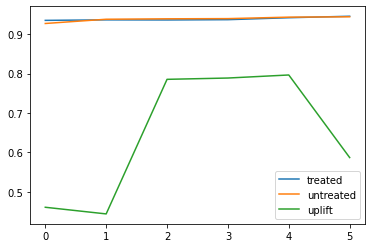

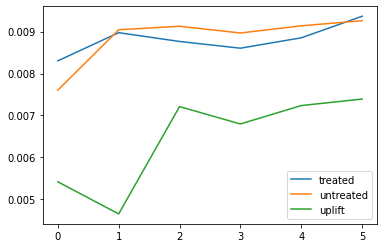

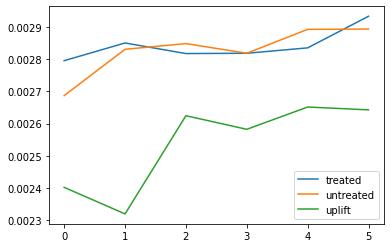

In [19]:
prct = [0.1,0.2,0.3,0.4,0.5, 1]
pd.DataFrame(aucs, columns=["treated", "untreated", "uplift"]).plot()
#plt.xticks(prct)
pd.DataFrame(rewards, columns=["treated", "untreated", "uplift"]).plot()
pd.DataFrame(effects, columns=["treated", "untreated", "uplift"]).plot()

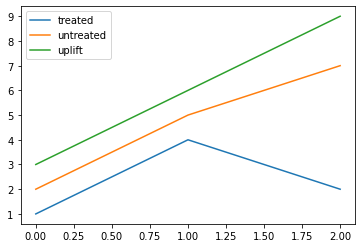

In [20]:
pd.DataFrame(np.array([[1,2,3],[4,5,6],[2,7,9]]), columns=["treated", "untreated", "uplift"]).plot()

In [21]:
import matplotlib.pyplot as plt
def draw_learning(reward_score,effect_score,a,b,step):
    x = [i for i in range(a,b,step)]
    plt.plot(x, reward_score,label = 'reward')
    #plt.plot(x, auc_score,label = 'auc_score')
    plt.plot(x, effect_score, label = 'effect on targeted')
    plt.xscale('log')
    plt.xlabel('# of train data')
    plt.ylabel('evaluation score')
    plt.legend()
def draw_learning_auc(auc_score,a,b,step):
    x = [i for i in range(a,b,step)]
    #plt.plot(x, reward_score,label = 'reward_score')
    plt.plot(x, auc_score,label = 'auc_score')
    #plt.plot(x, effect_score, label = 'effect_score')
    plt.xscale('log')
    plt.xlabel('# of train data')
    plt.ylabel('AUC score')
    plt.legend()

In [ ]:
draw_learning(reward_score,effect_score,10000,500000,10000)

NameError: ignored

In [ ]:
draw_learning_auc(auc_score,10000,500000,10000)

### AUC stops increasing at 100,000
### reward is constant at 0.003
### effect on targeted is around 0.004

In [ ]:
#reward_score1 = []
#effect_score1 = []
#for l in range(1000,train,10000):
    #model = build_classifier(df_all, 'conversion',l)
    #auc_score1.append(auc(model,'conversion'))
    #reward_score1.append(reward(model)[0])
    #effect_score1.append(reward(model)[1])

In [ ]:
draw_learning(reward_score1,effect_score1,1000,train,10000)

### Model 1: 
* AUC around 0.91 to 0.95 when # of train data >= 100,000
* reward constant around 0.3
* effect on targeted between (0.0030 to 0.0045)

## Model 3: Treated data, conversion

In [ ]:
auc_score3 = []
reward_score3 = []
effect_score3 = []
for l in prct:
    model = build_classifier(df_treated, 'conversion',l*len(df_treated))
    auc_score3.append(auc(model,'conversion'))
    reward_score3.append(reward(model)[0])
    effect_score3.append(reward(model)[1])

In [ ]:
#draw_learning(reward_score3,effect_score3,10000,500000,10000)

In [ ]:
#draw_learning_auc(auc_score3,10000,500000,10000)

## Model 5: Treated data, conversion

In [ ]:
auc_score5 = []
reward_score5 = []
effect_score5 = []
for l in prct:
    model = build_classifier(df_untreated, 'conversion',l*len(df_untreated))
    auc_score5.append(auc(model,'conversion'))
    reward_score5.append(reward(model)[0])
    effect_score5.append(reward(model)[1])

## Uplift (T-learner)

In [ ]:
# start with all untreated, increase treated data
auc_score_up2 = []
reward_score_up2 = []
effect_score_up2 = []
model_un = build_classifier(df_untreated, 'conversion',0.5*len(df_untreated))########## constant untreated for now
for l in prct:
    model_tr = build_classifier(df_treated, 'conversion',l*len(df_treated))
   
    auc_score_up2.append(auc_up(model_tr,model_un,'conversion'))
    reward_score_up2.append(reward_up(model_tr,model_un)[0])
    effect_score_up2.append(reward_up(model_tr,model_un)[1])

In [ ]:
# increase both treated and untreated data 10000,500000,10000
auc_score_up = []
reward_score_up = []
effect_score_up = []
for l in prct:
    model_tr = build_classifier(df_treated, 'conversion',l*len(df_untreated))
    model_un = build_classifier(df_untreated, 'conversion',l*len(df_untreated))########## constant untreated for now
    auc_score_up.append(auc_up(model_tr,model_un,'conversion'))
    reward_score_up.append(reward_up(model_tr,model_un)[0])
    effect_score_up.append(reward_up(model_tr,model_un)[1])

In [ ]:
def compare(auc_score,auc_score3,auc_score5,auc_score_up,auc_score_up2,title):

    x = prct
    plt.plot(x, auc_score,label = 'All')
    plt.plot(x, auc_score3,label = 'Treated')
    plt.plot(x, auc_score5,label = 'Untreated')
    plt.plot(x, auc_score_up,label = 'Uplift(varying both)')
    plt.plot(x, auc_score_up2,label = 'Uplift(varying treated data)')
    
    plt.xscale('log')

    plt.xlabel('# of train data')
    plt.ylabel(title)
    plt.legend()

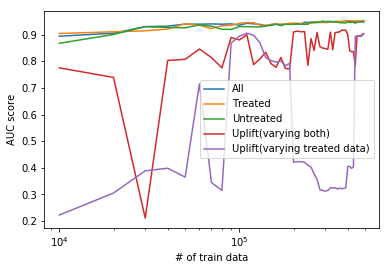

In [ ]:
compare(auc_score,auc_score3,auc_score5,auc_score_up,auc_score_up2,'AUC score')

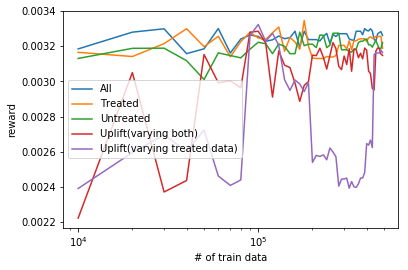

In [ ]:
compare(reward_score,reward_score3,reward_score5,reward_score_up,reward_score_up2,'reward') ##### why is reward going down

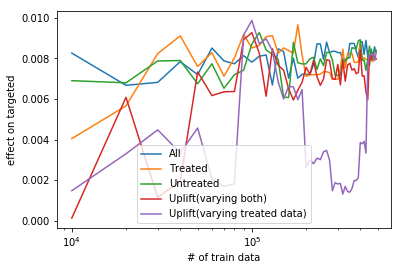

In [ ]:
compare(effect_score,effect_score3,effect_score5,effect_score_up,effect_score_up2,'effect on targeted')

### 200,000

## X-learner

In [ ]:
def x_learner(train):
    model_tr = build_classifier(df_treated, 'conversion',train)
    model_un = build_classifier(df_untreated, 'conversion',train)
    d1 = df_treated['conversion']-model_un.predict_proba(df_treated[features])[:, 1]
    d2 = model_tr.predict_proba(df_untreated[features])[:, 1]-df_untreated['conversion']
    df_d1 = df_treated[features]
    df_d2 = df_untreated[features]
    df_d1['d1'] = d1
    df_d2['d2'] = d2
    #print(df_d1.columns)
    model3 = build_classifier_regression(df_d1, 'd1',train) # what models to use for the second stage?
    model4 = build_classifier_regression(df_d2, 'd2',train)
    #0.85,0.15 (which one?)
    return model3, model4

In [ ]:
x_learner0 = x_learner(10000)[0]
x_learner1 = x_learner(10000)[1]

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

In [ ]:
auc_score_x = []
reward_score_x = []
effect_score_x = []
for l in range(10000,500000,10000):
    model0 = x_learner(l)[0]
    model1 = x_learner(l)[1]
   
    auc_score_x.append(auc_x(model0,model1,'conversion'))
    reward_score_x.append(reward_x(model0,model1)[0])
    effect_score_x.append(reward_x(model0,model1)[1])

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

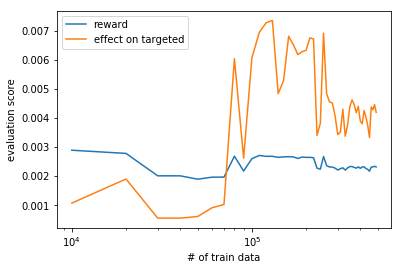

In [ ]:
draw_learning(reward_score_x,effect_score_x,10000,500000,10000)

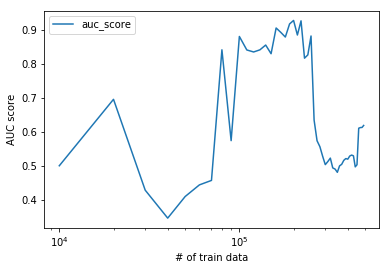

In [ ]:
draw_learning_auc(auc_score_x,10000,500000,10000)

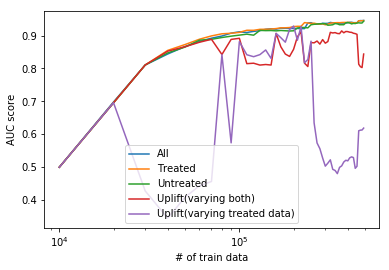

In [ ]:
compare(auc_score,auc_score3,auc_score5,auc_score_up,auc_score_x, 'AUC score')

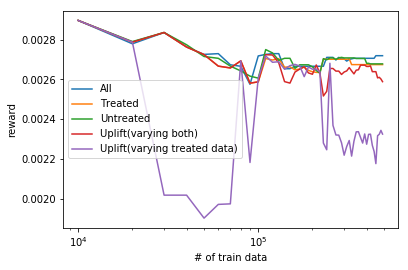

In [ ]:
compare(reward_score,reward_score3,reward_score5,reward_score_up,reward_score_x,'reward')

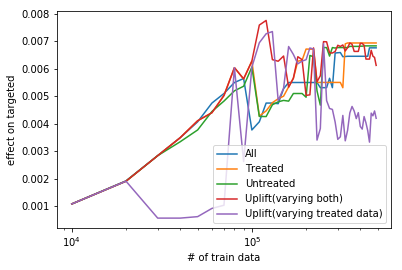

In [ ]:
compare(effect_score,effect_score3,effect_score5,effect_score_up,effect_score_x,'effect on targeted')